[![alt text](https://avatars1.githubusercontent.com/u/59831504?s=400&v=4 "MtheEPIC User Icon")](https://github.com/MtheEPIC/KaggleProj)

# Import Libraries

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set() 
from sklearn.preprocessing import binarize
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, plot_roc_curve
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [20]:
supSize = 25
titleSize = 20
labelSize = 15
tickSize = 13

---
# Setup Data

## Load & Display Data
[Kaggle Dataset](https://www.kaggle.com/ntnu-testimon/paysim1 "Synthetic Financial Datasets For Fraud Detection")

In [29]:
df = pd.read_csv('data/card.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## Check Value Type

In [4]:
print("data types\n{}".format(df.info()))
print("\nnull values:\n{}".format(df.isnull().sum()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
data types
None

null values:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


## Define Each Feature

### We have 11 initial features:

* **step:** Maps a unit of time in the real world. In this case 1 step is 1 hour of time, 743 is the end of the month
* **type:** CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER
* **amount:** amount of the transaction in local currency _(may be bigger then the account balance)_
* **nameOrig:** customer who started the transaction _(start with C for customer)_
* **oldbalanceOrg:** initial balance before the transaction _(at least 0)_
* **newbalanceOrig:** customer's balance after the transaction. _(at least 0)_
* **nameDest:** recipient ID of the transaction. _(start with C for customer)_
* **oldbalanceDest:** initial recipient balance before the transaction. _(at least 0)_
* **newbalanceDest:** recipient's balance after the transaction. _(at least 0)_
* **isFraud:** identifies a fraudulent transaction (1) and non fraudulent (0)
* **isFlaggedFraud:** flags illegal attempts to transfer more than 200.000 in a single transaction.

---
# Data Trends

### Transaction Types

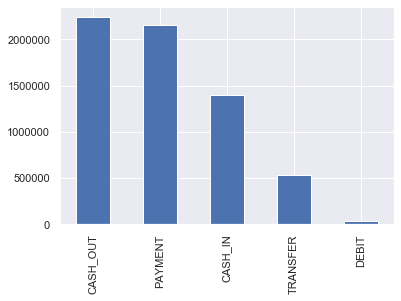

In [5]:
df['type'].value_counts().plot.bar()
plt.show()

In [6]:
precent = df['type'].value_counts(normalize=True)['DEBIT']*100
lines = df[df['type'] == 'DEBIT']['type'].value_counts()['DEBIT']
print("The precent of DEBIT in the Data Set is {:.2f}% ({} lines)".format(precent, lines))

The precent of DEBIT in the Data Set is 0.65% (41432 lines)


### Fraud happens aroud 0.13%

In [7]:
"{:.2f}%".format(df['isFraud'].value_counts(normalize=True)[1]*100)

'0.13%'

### Fraud is only in: TRANSFER, CASH OUT
#### (at about the same amount)

In [8]:
fraud = df[df['isFraud'] == 1]
fraud['type'].value_counts(normalize=True)*100

CASH_OUT    50.11567
TRANSFER    49.88433
Name: type, dtype: float64

### Precentage of Transfer Fraud is about 0.77%

In [9]:
df[df['type'] == 'TRANSFER']['isFraud'].value_counts(normalize=True)[1]*100

0.7687991758442811

### Precentage of Cash Out Fraud is about 0.18%

In [10]:
df[df['type'] == 'CASH_OUT']['isFraud'].value_counts(normalize=True)[1]*100

0.18395530726256984

### If The Transaction Amount Was The Same As The Balance: Its Fraud

In [11]:
df[df['amount'] == df['oldbalanceOrg']]['isFraud'].unique()

array([1], dtype=int64)

### If the Existing Fraud Detection Flags the Transaction as Fraud, It's Fraud

In [12]:
df[df['isFlaggedFraud'] == 1]['isFraud'].unique()

array([1], dtype=int64)

### All initiates are customers

In [13]:
df['nameOrig'].str[:1].unique()

array(['C'], dtype=object)

### Recipients are both customers and merchants

In [14]:
df['nameDest'].str[:1].unique()

array(['M', 'C'], dtype=object)

### proper recipients (merchants) do not fraud

In [15]:
df[df['isFraud']==1]['nameDest'].str[:1].unique()

array(['C'], dtype=object)

### Customers who Commited Fraud also Have Legit Transactions

In [16]:
fraudDoers = df[df['isFraud']==1]['nameDest'].unique()
df[df['nameDest']==fraudDoers[0]].head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
6167,6,TRANSFER,109985.65,C570434649,41851.00,0.00,C553264065,0.00,109985.65,0,0
7903,7,CASH_IN,10256.20,C111105514,3766080.24,3776336.45,C553264065,109985.65,99729.44,0,0
16381,8,CASH_OUT,111622.39,C1457214570,2347.00,0.00,C553264065,99729.44,5254.44,0,0
20003,8,CASH_IN,206097.39,C161724858,1991.12,208088.52,C553264065,211351.84,5254.44,0,0


### People who had been scamed had only one transaction in there acount

In [17]:
fraudRecipients = df[df['isFraud']==1]['nameOrig']
print(len(fraudRecipients))
print(len(fraudRecipients.unique()))

8213
8213


### People with only one transaction ...

In [18]:
fraudRecipients = df['nameOrig']
# print(len(fraudRecipients))
# print(len(fraudRecipients.unique()))
fraudRecipientsValues = fraudRecipients.value_counts()
fraudRecipientsValues[9298:]
df[df['isFraud']==1]['nameOrig']

2          C1305486145
3           C840083671
251        C1420196421
252        C2101527076
680         C137533655
              ...     
6362615     C786484425
6362616    C1529008245
6362617    C1162922333
6362618    C1685995037
6362619    C1280323807
Name: nameOrig, Length: 8213, dtype: object

### Though in general there are more Initiates then Recipients, In Fraudulent Transactions it's the other way

In [19]:
print("In Total:")
print("The Number Of Initiates is: {}".format(len(df['nameOrig'].unique())))
print("The Number Of Recipients is: {}".format(len(df['nameDest'].unique())))
print("In Fraudulent Transactions:")
print("The Number Of Initiates is: {}".format(len(df[df['isFraud']==1]['nameOrig'].unique())))
print("The Number Of Recipients is: {}".format(len(df[df['isFraud']==1]['nameDest'].unique())))

In Total:
The Number Of Initiates is: 6353307
The Number Of Recipients is: 2722362
In Fraudulent Transactions:
The Number Of Initiates is: 8213
The Number Of Recipients is: 8169


### Almost all of the fraudulent transactions where when the amount in the transaction was the same as the account balance

In [20]:
dfFraud = df[df['isFraud']==1][['amount', 'oldbalanceOrg']]
precent = dfFraud[dfFraud['amount']!=dfFraud['oldbalanceOrg']].shape[0]/dfFraud.shape[0]*100
print("The precentage of fraudulent transaction that didn't take the hull balace of the customer is {}%".format(precent))

The precentage of fraudulent transaction that didn't take the hull balace of the customer is 2.1794715694630464%


### The destination account doesn't seem to update according to the transferred amount, probebly to simulate the bank verifying the transaction

In [21]:
amount = df.loc[10]['amount']
delta = df.loc[10]['newbalanceDest'] - df.loc[10]['oldbalanceDest']
print('the amount transferred ({}) doesn\'t match the change in the destination account ({})'.format(amount, delta))

the amount transferred (9644.94) doesn't match the change in the destination account (147137.12)


---
# Predict Fraud

In [30]:
def normalize(df):
    for x in df:
        df[x] = df[x]/df[x].max()

In [31]:
# Existing fraud doesnt always work
df[df['amount']==df['oldbalanceOrg']]['isFlaggedFraud'].value_counts()

0    8024
1      10
Name: isFlaggedFraud, dtype: int64

In [32]:
df['myFraud'] = df['isFlaggedFraud']
size = len(df[df['amount']==df['oldbalanceOrg']]['myFraud'])
d1 = df[df['amount']==df['oldbalanceOrg']]['myFraud']
d2 = df[df['amount']!=df['oldbalanceOrg']]['myFraud']
d1 = d1.replace(0, 1)
df['myFraud'] = pd.concat([d1, d2])

In [33]:
df[df['amount']==df['oldbalanceOrg']]['myFraud'].value_counts()

1    8034
Name: myFraud, dtype: int64

## Clear data from unneeded values for the model

### remove transactions types with no fraud
otherwise the models will take to long

#### note that dummy classifiers makes models slow
```
tmp = pd.get_dummies(data['type'])
data = data.join(tmp)
data = data.drop('type', axis=1)
data.head()
```

In [26]:
# df[df['type'].isin(['TRANSFER', 'CASH_OUT'])]

In [34]:
d1 = df[df['type']=='TRANSFER']
d2 = df[df['type']=='CASH_OUT']
d1['type'] = 1
d2['type'] = 0
df = pd.concat([d1, d2])
df.head()

C:\Users\mthee\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\mthee\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,myFraud
2,1,1,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1,0,1
19,1,1,215310.30,C1670993182,705.00,0.0,C1100439041,22425.00,0.00,0,0,0
24,1,1,311685.89,C1984094095,10835.00,0.0,C932583850,6267.00,2719172.89,0,0,0
58,1,1,62610.80,C1976401987,79114.00,16503.2,C1937962514,517.00,8383.29,0,0,0
78,1,1,42712.39,C283039401,10363.39,0.0,C1330106945,57901.66,24044.18,0,0,0


### check if step helps in finding if fraud exists

isFraud    0
dtype: int64

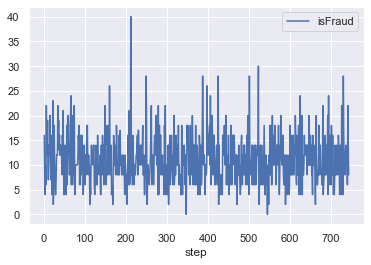

In [27]:
tmp = df[['step', 'isFraud']]
tmp.groupby(['step']).sum().plot()
tmp.groupby(['step']).sum().min()

change step to times of day 0-23

isFraud    274
dtype: int64

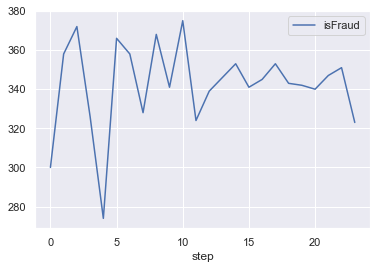

In [28]:
tmp = df[['step', 'isFraud']]%24
# tmp['step'] = tmp['step']%24
tmp.groupby(['step']).sum().plot()
tmp.groupby(['step']).sum().min()

C:\Users\mthee\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


isFraud    220
dtype: int64

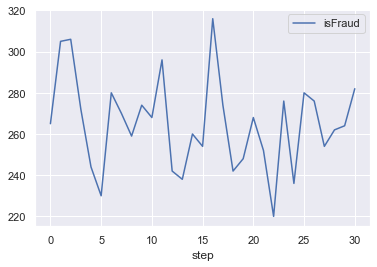

In [29]:
tmp = df[['step', 'isFraud']]
tmp['step'] = tmp['step']//24
tmp.groupby(['step']).sum().plot()
tmp.groupby(['step']).sum().min()

step doesn't realy help us

### Remove the unneeded columns

In [35]:
# df = df.drop(['nameOrig', 'nameDest'], axis=1)
df = df.select_dtypes(exclude='object')
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,myFraud
2,1,1,181.00,181.00,0.0,0.00,0.00,1,0,1
19,1,1,215310.30,705.00,0.0,22425.00,0.00,0,0,0
24,1,1,311685.89,10835.00,0.0,6267.00,2719172.89,0,0,0
58,1,1,62610.80,79114.00,16503.2,517.00,8383.29,0,0,0
78,1,1,42712.39,10363.39,0.0,57901.66,24044.18,0,0,0


In [36]:
normalize(df)
df_clean = df.copy()
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,myFraud
2,0.001346,1.0,0.000002,0.000003,0.000000,0.000000,0.000000,1.0,0.0,1.0
19,0.001346,1.0,0.002329,0.000012,0.000000,0.000063,0.000000,0.0,0.0,0.0
24,0.001346,1.0,0.003372,0.000182,0.000000,0.000018,0.007634,0.0,0.0,0.0
58,0.001346,1.0,0.000677,0.001328,0.000333,0.000001,0.000024,0.0,0.0,0.0
78,0.001346,1.0,0.000462,0.000174,0.000000,0.000163,0.000068,0.0,0.0,0.0


In [32]:
df = df.drop(['isFlaggedFraud', 'step'], axis=1)
df.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,myFraud
2,1.0,0.000002,0.000003,0.000000,0.000000,0.000000,1.0,1.0
19,1.0,0.002329,0.000012,0.000000,0.000063,0.000000,0.0,0.0
24,1.0,0.003372,0.000182,0.000000,0.000018,0.007634,0.0,0.0
58,1.0,0.000677,0.001328,0.000333,0.000001,0.000024,0.0,0.0
78,1.0,0.000462,0.000174,0.000000,0.000163,0.000068,0.0,0.0


In [33]:
X=df.drop('isFraud', axis=1)
y=df['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Train

In [37]:
def evaluate(true, pred):
    model_accuracy = roc_auc_score(true, pred)
    null_accuracy = roc_auc_score(true, true.replace(1, 0))
    
    print("Null AUC Score: {:.5f}".format(null_accuracy))
    print("Model AUC Score: {:.5f}".format(model_accuracy))

    if null_accuracy >= model_accuracy:
        print("The model isn't effective")
        return
    print("The model is better then a 'dumb' model")
    print("confusion_matrix:\n", confusion_matrix(true, pred))
    print(classification_report(true, pred))

### Decision Tree

In [35]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
predictions = dtc.predict(X_test)
evaluate(y_test, predictions)

Null AUC Score: 0.50000
Model AUC Score: 0.99761
The model is better then a 'dumb' model
confusion_matrix:
 [[552402      2]
 [     8   1670]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    552404
         1.0       1.00      1.00      1.00      1678

    accuracy                           1.00    554082
   macro avg       1.00      1.00      1.00    554082
weighted avg       1.00      1.00      1.00    554082



### Logistic Regression

In [36]:
lr = LogisticRegression(random_state=0, solver='lbfgs', max_iter=200)
lr.fit(X_train,y_train)
predictions = lr.predict(X_test)
evaluate(y_test, predictions)

Null AUC Score: 0.50000
Model AUC Score: 0.98868
The model is better then a 'dumb' model
confusion_matrix:
 [[552403      1]
 [    38   1640]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    552404
         1.0       1.00      0.98      0.99      1678

    accuracy                           1.00    554082
   macro avg       1.00      0.99      0.99    554082
weighted avg       1.00      1.00      1.00    554082



### RandomForestClassifier

In [37]:
rf = RandomForestClassifier(max_depth=None, random_state=0, n_estimators=10)
rf.fit(X_train, y_train)
predictions = rf.predict(X_test)
evaluate(y_test, predictions)

Null AUC Score: 0.50000
Model AUC Score: 0.99762
The model is better then a 'dumb' model
confusion_matrix:
 [[552404      0]
 [     8   1670]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    552404
         1.0       1.00      1.00      1.00      1678

    accuracy                           1.00    554082
   macro avg       1.00      1.00      1.00    554082
weighted avg       1.00      1.00      1.00    554082



In [38]:
rf = RandomForestClassifier(max_depth=5, random_state=0, n_estimators=10)
rf.fit(X_train, y_train)
predictions = rf.predict(X_test)
evaluate(y_test, predictions)

Null AUC Score: 0.50000
Model AUC Score: 0.99762
The model is better then a 'dumb' model
confusion_matrix:
 [[552404      0]
 [     8   1670]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    552404
         1.0       1.00      1.00      1.00      1678

    accuracy                           1.00    554082
   macro avg       1.00      1.00      1.00    554082
weighted avg       1.00      1.00      1.00    554082



### Linear SVC

In [39]:
svc = LinearSVC(random_state=0, tol=1e30)
svc.fit(X_train, y_train)
predictions = svc.predict(X_test)
evaluate(y_test, predictions)

Null AUC Score: 0.50000
Model AUC Score: 0.99761
The model is better then a 'dumb' model
confusion_matrix:
 [[552401      3]
 [     8   1670]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    552404
         1.0       1.00      1.00      1.00      1678

    accuracy                           1.00    554082
   macro avg       1.00      1.00      1.00    554082
weighted avg       1.00      1.00      1.00    554082



In [40]:
svc = LinearSVC(random_state=0, tol=1e-2)
svc.fit(X_train, y_train)
predictions = svc.predict(X_test)
evaluate(y_test, predictions)

Null AUC Score: 0.50000
Model AUC Score: 0.99762
The model is better then a 'dumb' model
confusion_matrix:
 [[552403      1]
 [     8   1670]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    552404
         1.0       1.00      1.00      1.00      1678

    accuracy                           1.00    554082
   macro avg       1.00      1.00      1.00    554082
weighted avg       1.00      1.00      1.00    554082



In [41]:
svc = LinearSVC(random_state=0, tol=1e-3)
svc.fit(X_train, y_train)
predictions = svc.predict(X_test)
evaluate(y_test, predictions)

Null AUC Score: 0.50000
Model AUC Score: 0.99762
The model is better then a 'dumb' model
confusion_matrix:
 [[552403      1]
 [     8   1670]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    552404
         1.0       1.00      1.00      1.00      1678

    accuracy                           1.00    554082
   macro avg       1.00      1.00      1.00    554082
weighted avg       1.00      1.00      1.00    554082



### Remove custom filter

In [38]:
df = df_clean
df = df.drop(['myFraud', 'step'], axis=1)
df.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1.0,0.000002,0.000003,0.000000,0.000000,0.000000,1.0,0.0
19,1.0,0.002329,0.000012,0.000000,0.000063,0.000000,0.0,0.0
24,1.0,0.003372,0.000182,0.000000,0.000018,0.007634,0.0,0.0
58,1.0,0.000677,0.001328,0.000333,0.000001,0.000024,0.0,0.0
78,1.0,0.000462,0.000174,0.000000,0.000163,0.000068,0.0,0.0


In [39]:
X=df.drop('isFraud', axis=1)
y=df['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Run models again

In [44]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
predictions = dtc.predict(X_test)
evaluate(y_test, predictions)

Null AUC Score: 0.50000
Model AUC Score: 0.94086
The model is better then a 'dumb' model
confusion_matrix:
 [[552247    157]
 [   198   1480]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    552404
         1.0       0.90      0.88      0.89      1678

    accuracy                           1.00    554082
   macro avg       0.95      0.94      0.95    554082
weighted avg       1.00      1.00      1.00    554082



In [45]:
lr = LogisticRegression(random_state=0, solver='lbfgs', max_iter=200)
lr.fit(X_train,y_train)
predictions = lr.predict(X_test)
evaluate(y_test, predictions)

Null AUC Score: 0.50000
Model AUC Score: 0.54708
The model is better then a 'dumb' model
confusion_matrix:
 [[552400      4]
 [  1520    158]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    552404
         1.0       0.98      0.09      0.17      1678

    accuracy                           1.00    554082
   macro avg       0.99      0.55      0.59    554082
weighted avg       1.00      1.00      1.00    554082



In [46]:
rf = RandomForestClassifier(max_depth=None, random_state=0, n_estimators=10)
rf.fit(X_train, y_train)
predictions = rf.predict(X_test)
evaluate(y_test, predictions)

Null AUC Score: 0.50000
Model AUC Score: 0.88169
The model is better then a 'dumb' model
confusion_matrix:
 [[552386     18]
 [   397   1281]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    552404
         1.0       0.99      0.76      0.86      1678

    accuracy                           1.00    554082
   macro avg       0.99      0.88      0.93    554082
weighted avg       1.00      1.00      1.00    554082



In [47]:
svc = LinearSVC(random_state=0, tol=1e-2)
svc.fit(X_train, y_train)
predictions = svc.predict(X_test)
evaluate(y_test, predictions)

Null AUC Score: 0.50000
Model AUC Score: 0.60786
The model is better then a 'dumb' model
confusion_matrix:
 [[552399      5]
 [  1316    362]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    552404
         1.0       0.99      0.22      0.35      1678

    accuracy                           1.00    554082
   macro avg       0.99      0.61      0.68    554082
weighted avg       1.00      1.00      1.00    554082



## Improve Models

### Logistic Regression

In [40]:
lr = LogisticRegression(random_state=0, solver='lbfgs', max_iter=200)
lr.fit(X_train,y_train)
predictions = lr.predict(X_test)
evaluate(y_test, predictions)

Null AUC Score: 0.50000
Model AUC Score: 0.54708
The model is better then a 'dumb' model
confusion_matrix:
 [[552400      4]
 [  1520    158]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    552404
         1.0       0.98      0.09      0.17      1678

    accuracy                           1.00    554082
   macro avg       0.99      0.55      0.59    554082
weighted avg       1.00      1.00      1.00    554082



In [44]:
y_pred = lr.predict_proba(X_test)[:, 1]
y_pred_class = binarize([y_pred], 2e-3)[0]
evaluate(y_test, y_pred_class)

Null AUC Score: 0.50000
Model AUC Score: 0.80961
The model is better then a 'dumb' model
confusion_matrix:
 [[418110 134294]
 [   231   1447]]
              precision    recall  f1-score   support

         0.0       1.00      0.76      0.86    552404
         1.0       0.01      0.86      0.02      1678

    accuracy                           0.76    554082
   macro avg       0.51      0.81      0.44    554082
weighted avg       1.00      0.76      0.86    554082



In [43]:
y_pred_class = binarize([y_pred], 1e-3)[0]
evaluate(y_test, y_pred_class)

Null AUC Score: 0.50000
Model AUC Score: 0.51332
The model is better then a 'dumb' model
confusion_matrix:
 [[ 17681 534723]
 [     9   1669]]
              precision    recall  f1-score   support

         0.0       1.00      0.03      0.06    552404
         1.0       0.00      0.99      0.01      1678

    accuracy                           0.03    554082
   macro avg       0.50      0.51      0.03    554082
weighted avg       1.00      0.03      0.06    554082



### Random forest

In [52]:
rf = RandomForestClassifier(max_depth=None, random_state=0, n_estimators=10)
rf.fit(X_train, y_train)
predictions = rf.predict(X_test)
evaluate(y_test, predictions)

Null AUC Score: 0.50000
Model AUC Score: 0.88169
The model is better then a 'dumb' model
confusion_matrix:
 [[552386     18]
 [   397   1281]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    552404
         1.0       0.99      0.76      0.86      1678

    accuracy                           1.00    554082
   macro avg       0.99      0.88      0.93    554082
weighted avg       1.00      1.00      1.00    554082



In [53]:
parm_grid = dict(n_estimators=np.arange(6, 13, 1), min_samples_leaf=np.arange(1, 4), max_features=[None, 'log2', 'sqrt'])
grid = RandomizedSearchCV(rf, parm_grid, cv=3, scoring='roc_auc', n_iter=2, random_state=0)
# grid = GridSearchCV(clf, parm_grid, cv=10, scoring='roc_auc')
grid.fit(X_train, y_train)
print(grid.best_params_)

{'n_estimators': 6, 'min_samples_leaf': 2, 'max_features': 'sqrt'}


In [54]:
rf = grid.best_estimator_
rf.fit(X_train, y_train)
predictions = rf.predict(X_test)
evaluate(y_test, predictions)

Null AUC Score: 0.50000
Model AUC Score: 0.88288
The model is better then a 'dumb' model
confusion_matrix:
 [[552382     22]
 [   393   1285]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    552404
         1.0       0.98      0.77      0.86      1678

    accuracy                           1.00    554082
   macro avg       0.99      0.88      0.93    554082
weighted avg       1.00      1.00      1.00    554082



In [55]:
rfBoost = AdaBoostClassifier(base_estimator=rf, n_estimators=10, random_state=0)
rfBoost.fit(X_train, y_train)
predictions = rfBoost.predict(X_test)
evaluate(y_test, predictions)

Null AUC Score: 0.50000
Model AUC Score: 0.90102
The model is better then a 'dumb' model
confusion_matrix:
 [[552346     58]
 [   332   1346]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    552404
         1.0       0.96      0.80      0.87      1678

    accuracy                           1.00    554082
   macro avg       0.98      0.90      0.94    554082
weighted avg       1.00      1.00      1.00    554082



In [56]:
# grid adaboost
parm_grid = dict(n_estimators=np.arange(5, 15, 1), learning_rate=np.linspace(0, 3, 30))
grid = RandomizedSearchCV(rfBoost, parm_grid, cv=3, scoring='roc_auc', n_iter=2, random_state=0, n_jobs=4)
grid.fit(X_train, y_train)
print(grid.best_params_)
predictions = grid.predict(X_test)
evaluate(y_test, predictions)

{'n_estimators': 7, 'learning_rate': 1.7586206896551724}
Null AUC Score: 0.50000
Model AUC Score: 0.89982
The model is better then a 'dumb' model
confusion_matrix:
 [[552340     64]
 [   336   1342]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    552404
         1.0       0.95      0.80      0.87      1678

    accuracy                           1.00    554082
   macro avg       0.98      0.90      0.93    554082
weighted avg       1.00      1.00      1.00    554082



In [57]:
rf = RandomForestClassifier(max_depth=None, random_state=0, n_estimators=10)
rf.fit(X_train, y_train)
predictions = rf.predict(X_test)
evaluate(y_test, predictions)

Null AUC Score: 0.50000
Model AUC Score: 0.88169
The model is better then a 'dumb' model
confusion_matrix:
 [[552386     18]
 [   397   1281]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    552404
         1.0       0.99      0.76      0.86      1678

    accuracy                           1.00    554082
   macro avg       0.99      0.88      0.93    554082
weighted avg       1.00      1.00      1.00    554082



In [58]:
rfBoost = AdaBoostClassifier(base_estimator=rf, n_estimators=10, random_state=0)
rfBoost.fit(X_train, y_train)
predictions = rfBoost.predict(X_test)
evaluate(y_test, predictions)

Null AUC Score: 0.50000
Model AUC Score: 0.89626
The model is better then a 'dumb' model
confusion_matrix:
 [[552354     50]
 [   348   1330]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    552404
         1.0       0.96      0.79      0.87      1678

    accuracy                           1.00    554082
   macro avg       0.98      0.90      0.93    554082
weighted avg       1.00      1.00      1.00    554082



In [59]:
# grid adaboost
parm_grid = dict(n_estimators=np.arange(5, 15, 1), learning_rate=np.linspace(0, 3, 30))
grid = RandomizedSearchCV(rfBoost, parm_grid, cv=3, scoring='roc_auc', n_iter=2, random_state=0, n_jobs=4)
grid.fit(X_train, y_train)
print(grid.best_params_)
rfBoostCV = grid.best_estimator_
predictions = grid.predict(X_test)
evaluate(y_test, predictions)

{'n_estimators': 7, 'learning_rate': 1.7586206896551724}
Null AUC Score: 0.50000
Model AUC Score: 0.89923
The model is better then a 'dumb' model
confusion_matrix:
 [[552339     65]
 [   338   1340]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    552404
         1.0       0.95      0.80      0.87      1678

    accuracy                           1.00    554082
   macro avg       0.98      0.90      0.93    554082
weighted avg       1.00      1.00      1.00    554082



### Decision tree

In [60]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
predictions = dtc.predict(X_test)
evaluate(y_test, predictions)

Null AUC Score: 0.50000
Model AUC Score: 0.94145
The model is better then a 'dumb' model
confusion_matrix:
 [[552240    164]
 [   196   1482]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    552404
         1.0       0.90      0.88      0.89      1678

    accuracy                           1.00    554082
   macro avg       0.95      0.94      0.95    554082
weighted avg       1.00      1.00      1.00    554082



In [61]:
dtcBoost = AdaBoostClassifier(base_estimator=dtc, n_estimators=50, random_state=0)
dtcBoost.fit(X_train, y_train)
predictions = dtcBoost.predict(X_test)
evaluate(y_test, predictions)

Null AUC Score: 0.50000
Model AUC Score: 0.95299
The model is better then a 'dumb' model
confusion_matrix:
 [[552147    257]
 [   157   1521]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    552404
         1.0       0.86      0.91      0.88      1678

    accuracy                           1.00    554082
   macro avg       0.93      0.95      0.94    554082
weighted avg       1.00      1.00      1.00    554082



In [62]:
# parm_grid = dict(n_estimators=np.arange(5, 100, 5), learning_rate=np.linspace(0.5, 1.5, 5))
# grid = RandomizedSearchCV(dtcBoost, parm_grid, cv=5, scoring='roc_auc', n_iter=2, random_state=0, n_jobs=6)
# grid.fit(X_train, y_train)
# print(grid.best_score_)
# print(grid.best_params_)
# predictions = grid.predict(X_test)
# evaluate(y_test, predictions)

### Gaussian naive bayes

In [63]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
predictions = gnb.predict(X_test)
evaluate(y_test, predictions)

Null AUC Score: 0.50000
Model AUC Score: 0.67267
The model is better then a 'dumb' model
confusion_matrix:
 [[547622   4782]
 [  1084    594]]
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99    552404
         1.0       0.11      0.35      0.17      1678

    accuracy                           0.99    554082
   macro avg       0.55      0.67      0.58    554082
weighted avg       1.00      0.99      0.99    554082



In [64]:
gnbBoost = AdaBoostClassifier(base_estimator=gnb, n_estimators=100, random_state=0)
gnbBoost.fit(X_train, y_train)
predictions = gnbBoost.predict(X_test)
evaluate(y_test, predictions)

Null AUC Score: 0.50000
Model AUC Score: 0.71883
The model is better then a 'dumb' model
confusion_matrix:
 [[372786 179618]
 [   398   1280]]
              precision    recall  f1-score   support

         0.0       1.00      0.67      0.81    552404
         1.0       0.01      0.76      0.01      1678

    accuracy                           0.68    554082
   macro avg       0.50      0.72      0.41    554082
weighted avg       1.00      0.68      0.80    554082



## Plot AUC score of the models

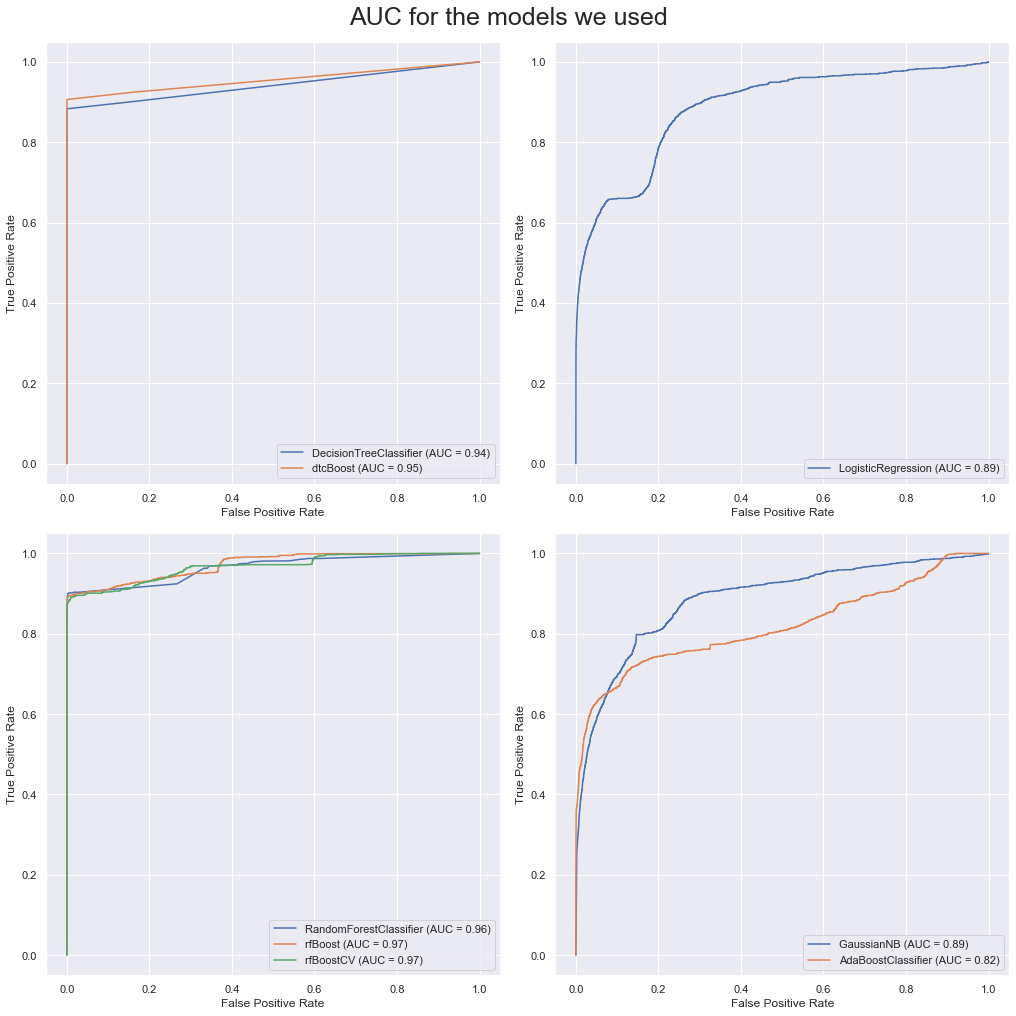

In [65]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 14), constrained_layout=True)
plot_roc_curve(dtc, X_test, y_test, ax=ax1)
plot_roc_curve(dtcBoost, X_test, y_test, ax=ax1, name='dtcBoost')
plot_roc_curve(lr, X_test, y_test, ax=ax2)
plot_roc_curve(rf, X_test, y_test, ax=ax3)
plot_roc_curve(rfBoost, X_test, y_test, ax=ax3, name='rfBoost')
plot_roc_curve(rfBoostCV, X_test, y_test, ax=ax3, name='rfBoostCV')
# plot_roc_curve(svc, X_test, y_test, ax=ax)
plot_roc_curve(gnb, X_test, y_test, ax=ax4)
plot_roc_curve(gnbBoost, X_test, y_test, ax=ax4)

fig.suptitle ('AUC for the models we used', fontsize=supSize)
# ax.set_title('AUC for the models we used', fontsize=titleSize)
# ax.set_xlabel('Top Most Common Apps', fontsize=labelSize)
# ax.set_ylabel('App Size In Mb', fontsize=labelSize)
# ax.set_xticklabels(ax.get_xticklabels(), fontsize=tickSize)
# ax.set_yticklabels(ax.get_yticklabels(), fontsize=tickSize)

plt.show()

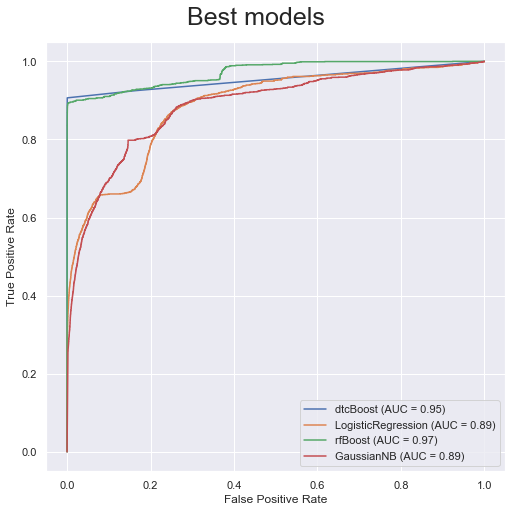

In [66]:
fig, ax = plt.subplots(figsize=(7, 7), constrained_layout=True)

plot_roc_curve(dtcBoost, X_test, y_test, ax=ax, name='dtcBoost')
plot_roc_curve(lr, X_test, y_test, ax=ax)
plot_roc_curve(rfBoost, X_test, y_test, ax=ax, name='rfBoost')
plot_roc_curve(gnb, X_test, y_test, ax=ax)

fig.suptitle ('Best models', fontsize=supSize)

plt.show()

in conclusion the best model is a Random forest with Adaboost

In [67]:
#fix score to be better

In [68]:
predictions = rfBoost.predict(X_test)
evaluate(y_test, predictions)

Null AUC Score: 0.50000
Model AUC Score: 0.89626
The model is better then a 'dumb' model
confusion_matrix:
 [[552354     50]
 [   348   1330]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    552404
         1.0       0.96      0.79      0.87      1678

    accuracy                           1.00    554082
   macro avg       0.98      0.90      0.93    554082
weighted avg       1.00      1.00      1.00    554082



In [45]:
rf = RandomForestClassifier(max_depth=None, random_state=0, n_estimators=10)
rf.fit(X_train, y_train)
predictions = rf.predict(X_test)
evaluate(y_test, predictions)

Null AUC Score: 0.50000
Model AUC Score: 0.88169
The model is better then a 'dumb' model
confusion_matrix:
 [[552386     18]
 [   397   1281]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    552404
         1.0       0.99      0.76      0.86      1678

    accuracy                           1.00    554082
   macro avg       0.99      0.88      0.93    554082
weighted avg       1.00      1.00      1.00    554082



In [136]:
from sklearn.metrics import roc_curve

y_pred = rf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
start = 150
end = 163
# print(thr)
print("default:")
y_pred_class = binarize([y_pred], 5e-1)[0]
evaluate(y_test, y_pred_class)

for i in range(107, 110, 1): #108 is 0.94353
    y_pred_class = binarize([y_pred], thresholds[i])[0]
    print("index: ", i)
    evaluate(y_test, y_pred_class)

# for i in range(start, end, 3):
#     y_pred_class = binarize([y_pred], thresholds[i])[0]
#     print("index: ", i)
#     evaluate(y_test, y_pred_class)
    


# print(fpr)
# print(tpr)

default:
Null AUC Score: 0.50000
Model AUC Score: 0.88169
The model is better then a 'dumb' model
confusion_matrix:
 [[552386     18]
 [   397   1281]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    552404
         1.0       0.99      0.76      0.86      1678

    accuracy                           1.00    554082
   macro avg       0.99      0.88      0.93    554082
weighted avg       1.00      1.00      1.00    554082

index:  106
Null AUC Score: 0.50000
Model AUC Score: 0.94324
The model is better then a 'dumb' model
confusion_matrix:
 [[551586    818]
 [   188   1490]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    552404
         1.0       0.65      0.89      0.75      1678

    accuracy                           1.00    554082
   macro avg       0.82      0.94      0.87    554082
weighted avg       1.00      1.00      1.00    554082

index:  107
Null AUC Score: 0.50000
Mod

In [82]:
rfBoost = AdaBoostClassifier(base_estimator=rf, n_estimators=10, random_state=0)
rfBoost.fit(X_train, y_train)
predictions = rfBoost.predict(X_test)
evaluate(y_test, predictions)

Null AUC Score: 0.50000
Model AUC Score: 0.89626
The model is better then a 'dumb' model
confusion_matrix:
 [[552354     50]
 [   348   1330]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    552404
         1.0       0.96      0.79      0.87      1678

    accuracy                           1.00    554082
   macro avg       0.98      0.90      0.93    554082
weighted avg       1.00      1.00      1.00    554082



In [89]:
y_pred = rfBoost.predict_proba(X_test)[:, 1]
y_pred_class = binarize([y_pred], 3e-1)[0]
evaluate(y_test, y_pred_class)

Null AUC Score: 0.50000
Model AUC Score: 0.93388
The model is better then a 'dumb' model
confusion_matrix:
 [[552103    301]
 [   221   1457]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    552404
         1.0       0.83      0.87      0.85      1678

    accuracy                           1.00    554082
   macro avg       0.91      0.93      0.92    554082
weighted avg       1.00      1.00      1.00    554082



In [73]:
# rfBoost = AdaBoostClassifier(base_estimator=rf, n_estimators=20, learning_rate=1, random_state=0)
# rfBoost.fit(X_train, y_train)
# predictions = rfBoost.predict(X_test)
# evaluate(y_test, predictions)

Null AUC Score: 0.50000
Model AUC Score: 0.89863
The model is better then a 'dumb' model
confusion_matrix:
 [[552343     61]
 [   340   1338]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    552404
         1.0       0.96      0.80      0.87      1678

    accuracy                           1.00    554082
   macro avg       0.98      0.90      0.93    554082
weighted avg       1.00      1.00      1.00    554082



In [72]:
# rfBoost = AdaBoostClassifier(base_estimator=rf, n_estimators=20, learning_rate=0.5, random_state=0)
# rfBoost.fit(X_train, y_train)
# predictions = rfBoost.predict(X_test)
# evaluate(y_test, predictions)

Null AUC Score: 0.50000
Model AUC Score: 0.89359
The model is better then a 'dumb' model
confusion_matrix:
 [[552364     40]
 [   357   1321]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    552404
         1.0       0.97      0.79      0.87      1678

    accuracy                           1.00    554082
   macro avg       0.98      0.89      0.93    554082
weighted avg       1.00      1.00      1.00    554082



In [ ]:
cross_val_score
#     print(average_precision_score(y_test, y_pred_class))